<h1 style="text-align: center;"> Nursery prediction model</h1>



Nursery Database was derived from a hierarchical decision model originally developed to rank applications for nursery schools. It was used during several years in 1980's when there was excessive enrollment to these schools in Ljubljana, Slovenia, and the rejected applications frequently needed an objective explanation. 

# Load data

In [33]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("nursery.csv", sep=",")

In [3]:
data

,parents,has_nurs,form,children,housing,finance,social,health,final evaluation
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority
...,...,...,...,...,...,...,...,...,...
12955,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,priority,spec_prior
12956,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,not_recom,not_recom
12957,great_pret,very_crit,foster,more,critical,inconv,problematic,recommended,spec_prior
12958,great_pret,very_crit,foster,more,critical,inconv,problematic,priority,spec_prior


## Features meaning
 
 parents   $~~~~~~~~~~~$  Parents' occupation \
 has_nurs   $~~~~~~~~~~~$  Child's nursery \
 form   $~~~~~~~~~~~$  Form of the family \
 children   $~~~~~~~~~~~$  Number of children \
 housing   $~~~~~~~~~~~$  Housing conditions \
 finance   $~~~~~~~~~~~$  Financial standing of the family \
 social   $~~~~~~~~~~~$  Social conditions \
 health   $~~~~~~~~~~~$  Health conditions 


# Data processing

The data needs to be pre-processed in order to encode the categorical features onto integers. We also need to separate the featuress from the target.

In [4]:
X = data.loc[:, data.columns != 'final evaluation' ]
y = data.loc[:, data.columns == 'final evaluation' ]

In [5]:
X

,parents,has_nurs,form,children,housing,finance,social,health
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended
1,usual,proper,complete,1,convenient,convenient,nonprob,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority
...,...,...,...,...,...,...,...,...
12955,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,priority
12956,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,not_recom
12957,great_pret,very_crit,foster,more,critical,inconv,problematic,recommended
12958,great_pret,very_crit,foster,more,critical,inconv,problematic,priority


In [6]:
y

,final evaluation
0,recommend
1,priority
2,not_recom
3,recommend
4,priority
...,...
12955,spec_prior
12956,not_recom
12957,spec_prior
12958,spec_prior


In [7]:
y['final evaluation'] = y['final evaluation'].astype('category')
y['final evaluation']  = y['final evaluation'] .cat.codes
y

,final evaluation
0,2
1,1
2,0
3,2
4,1
...,...
12955,3
12956,0
12957,3
12958,3


In [8]:
columns = X.columns

onehot = []
for label in columns:   
    X[label] = X[label].astype('category')
    X[label]  = X[label].cat.codes
X

,parents,has_nurs,form,children,housing,finance,social,health
0,2,3,0,0,0,0,0,2
1,2,3,0,0,0,0,0,1
2,2,3,0,0,0,0,0,0
3,2,3,0,0,0,0,2,2
4,2,3,0,0,0,0,2,1
...,...,...,...,...,...,...,...,...
12955,0,4,2,3,1,1,2,1
12956,0,4,2,3,1,1,2,0
12957,0,4,2,3,1,1,1,2
12958,0,4,2,3,1,1,1,1


Now we separate our data set into training set and test set.

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
X_train

,parents,has_nurs,form,children,housing,finance,social,health
5418,1,2,1,0,2,0,0,2
11573,0,0,1,2,0,1,1,0
11260,0,0,0,0,2,1,0,1
1365,2,2,3,1,0,1,1,2
3145,2,0,3,2,0,1,2,1
...,...,...,...,...,...,...,...,...
79,2,3,0,1,2,0,1,1
12119,0,4,0,0,2,0,2,0
8039,1,4,1,0,1,1,0,0
6936,1,0,0,0,2,0,1,2


Last encoding according to xgboost format requirements

In [34]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

y_train.reshape(y_train.shape[0],)
y_test.reshape(y_test.shape[0],)

array([0, 0, 1, ..., 0, 3, 3])

# First model


Some utilities for calculating model accuracy

In [26]:
def accuracy(predictions, groundtruth):
    return sum(predictions == groundtruth)/groundtruth.shape[0]

In [27]:
def compute_accuracy(model, X_train, X_test, y_train, y_test):
    predictions_train = model.predict(X_train)
    predictions_test = model.predict(X_test)

    return {"Train accuracy" : accuracy(predictions_train, y_train), "Test accuracy" : accuracy(predictions_test, y_test)}

Let's try a simple model with 10 trees.
We choose the cross entropy as the objective function.

In [28]:
from xgboost import XGBClassifier
from xgboost import plot_importance

model = XGBClassifier(objective='binary:logistic', 
                      num_class=5, 
                      eval_metric='mlogloss',
                      tree_method='gpu_hist',
                      n_estimators = 10,
                      verbosity=0)


In [29]:
model.fit(X_train, y_train)

XGBClassifier(eval_metric='mlogloss', n_estimators=10, num_class=5,
              objective='multi:softprob', tree_method='gpu_hist', verbosity=0)

In [30]:
compute_accuracy(model, X_train, X_test, y_train, y_test)

{'Train accuracy': 0.8653549382716049, 'Test accuracy': 0.8603395061728395}

Accuracy on training set and on the test set are close. So there's no sign of overfitting. An accuracy of 86% is  good, but let's see if we can improve on that.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

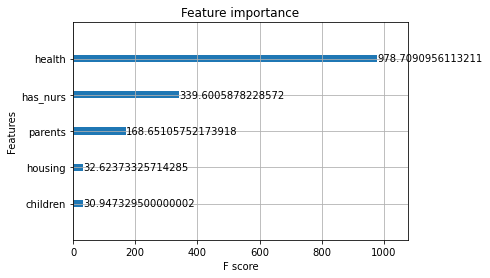

In [16]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 10)

plot_importance(model, importance_type="gain")

Here is a display of the features that have gained the most information. Three features stand out from the rest: health, has_nurse, parents. The parents' situation and the child's state of health play an important role in the decision. The fact that the child has a nurse obviously plays an important role in deciding who should give priority to the nursery.

# Model tuning

Use the GridSearch method to find good hyperparameters.
We focus on the max_depth and n_estimators parameters, which describe the maximum depth and number of trees. We'll be looking for a good L1 regularization to induce feature selection.
To avoid generating an overfitting model, we're also looking for a good L2 regularization.


In [17]:
search_spaces = {'max_depth': [2,5,7,10],
                 'reg_lambda': [0.1,0.01,0.001,1,10], 
                 'reg_alpha': [0.1,0.01,0.001,1,10], 
                 'n_estimators': [10,30,50,100]
   }

In [19]:
from sklearn.model_selection import GridSearchCV

optimized_model = XGBClassifier(objective='binary:logistic', 
                      num_class=5, 
                      eval_metric='mlogloss',
                      tree_method='gpu_hist',
                      verbosity=0)

grid_result = GridSearchCV(optimized_model,
                      param_grid=search_spaces,
                      scoring='accuracy',
                      cv=3,
                      verbose=1)
grid_result.fit(X_train, y_train)


Fitting 3 folds for each of 400 candidates, totalling 1200 fits


/home/gmg/miniconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=XGBClassifier(eval_metric='merror', num_class=5,
                                     objective='multi:softmax',
                                     tree_method='gpu_hist', verbosity=0),
             param_grid={'max_depth': [2, 5, 7, 10],
                         'n_estimators': [10, 30, 50, 100],
                         'reg_alpha': [0.1, 0.01, 0.001, 1, 10],
                         'reg_lambda': [0.1, 0.01, 0.001, 1, 10]},
             scoring='accuracy', verbose=1)

In [20]:

grid_result.best_params_

{'max_depth': 7, 'n_estimators': 100, 'reg_alpha': 0.01, 'reg_lambda': 0.01}

Let's test the new parameters.

In [31]:
optimized_model = XGBClassifier(objective='binary:logistic', 
                      num_class=5, 
                      eval_metric='mlogloss',
                      tree_method='gpu_hist',
                        max_depth = grid_result.best_params_['max_depth'],
                        n_estimators = grid_result.best_params_['n_estimators'],
                        reg_alpha = grid_result.best_params_['reg_alpha'],
                        reg_lambda = grid_result.best_params_['reg_lambda'],
                      verbosity=0)
optimized_model.fit(X_train, y_train)


XGBClassifier(eval_metric='mlogloss', max_depth=7, num_class=5,
              objective='multi:softprob', reg_alpha=0.01, reg_lambda=0.01,
              tree_method='gpu_hist', verbosity=0)

In [32]:
compute_accuracy(optimized_model, X_train, X_test, y_train, y_test)

{'Train accuracy': 0.9999035493827161, 'Test accuracy': 0.9996141975308642}

We've managed to improve the accuracy of the model. Both accuracies are in the order of 99%. There's no sign of overfitting, as both accuaruacy are similar. We can now predict the veridct of an applications for nursery schools with excellent precision. 